In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import scipy
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel, LabelModelInd
from metal.label_model.graph_utils import JunctionTree
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


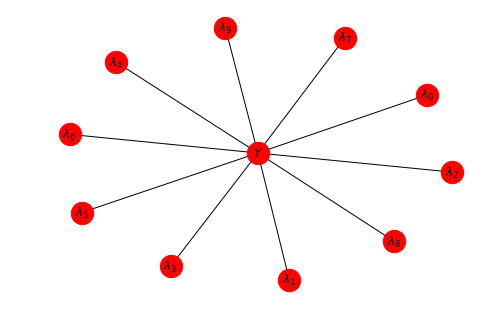

In [2]:
M = 10
N_CLUSTERS = 10
EDGE_PROB = 0.0
deps_graph = ClusterDependencies(M, N_CLUSTERS, edge_prob=EDGE_PROB)
# deps_graph = ChainDependencies(M)
deps_graph.draw()

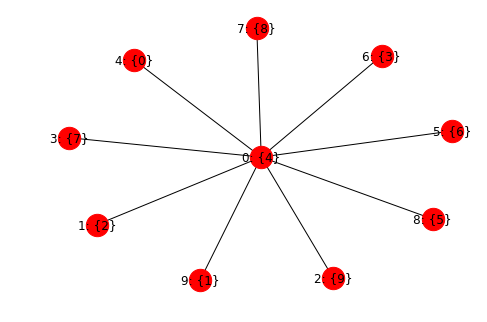

In [3]:
N = 1000 # Not used yet...
K = 3
HIGHER_ORDER_CLIQUES = True

data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
data.jt.draw()

In [4]:
%time sigma_O = data.get_sigma_O()

CPU times: user 461 ms, sys: 3.32 ms, total: 464 ms
Wall time: 465 ms


In [5]:
np.linalg.cond(sigma_O)

9.353757603889203

In [6]:
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])

In [7]:
class_balance = data.get_class_balance()
class_balance

array([0.23784284, 0.54343937, 0.21871779])

In [8]:
lm = LabelModel(k=3)

lm.train(
    sigma_O=sigma_O,
    E_O=E_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000,
    l2=0
)

mu = data.get_mu()
np.mean(np.abs(mu - lm.mu))

Estimating Z...
[E:0]	Train Loss: 789.43347168
[E:1000]	Train Loss: 0.00000000
[E:2000]	Train Loss: 0.00000000
[E:3000]	Train Loss: 0.00000000
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training


0.05944430880253493

In [9]:
C = np.diag([1,1])
sigma_OH_est = lm.get_sigma_OH(C)
sigma_OH = data.get_sigma_OH()

print(np.mean(np.abs(sigma_OH - sigma_OH_est)))

np.hstack([sigma_OH_est, sigma_OH])

0.047148843807252885


array([[-0.03580864, -0.01406238,  0.05831557, -0.02665686],
       [-0.02205543,  0.03176161, -0.01233729,  0.03046126],
       [-0.03691479, -0.03582252,  0.08557477, -0.05221247],
       [ 0.00042955,  0.05288052, -0.06362476,  0.06145143],
       [ 0.0023571 , -0.02514049,  0.02727808, -0.02847509],
       [-0.00336208,  0.01691659, -0.01629521,  0.01864713],
       [-0.07679615, -0.01541809,  0.10746855, -0.04007401],
       [ 0.00452609,  0.02266828, -0.03230953,  0.02759715],
       [ 0.0097717 , -0.04894303,  0.04709363, -0.05393697],
       [-0.02100114,  0.0410389 , -0.02463484,  0.04152511],
       [-0.05528537, -0.02251179,  0.09098994, -0.04208445],
       [ 0.01843102,  0.0512431 , -0.08254699,  0.06475466],
       [-0.0328444 , -0.05976853,  0.10943998, -0.07880718],
       [-0.02015547,  0.06566519, -0.05501346,  0.07032944],
       [-0.06281275, -0.01571999,  0.09161192, -0.03638309],
       [ 0.02564366,  0.04989156, -0.08929833,  0.06527161],
       [-0.05248304,  0.

In [10]:
Z_est = lm.Z.detach().numpy()
Z_est

array([[ 0.314044  ,  0.30599415],
       [ 0.01405511,  0.37424147],
       [ 0.337298  ,  0.20304817],
       [-0.3586488 ,  0.3080262 ],
       [ 0.18109334, -0.07105096],
       [-0.05964185,  0.04159088],
       [ 0.6358802 ,  0.5058101 ],
       [ 0.08072864,  0.3864143 ],
       [ 0.36301592, -0.10671239],
       [-0.01595854,  0.14451914],
       [ 0.21675432,  0.3298481 ],
       [-0.56605804,  0.3049168 ],
       [ 0.6378502 ,  0.21129419],
       [-0.29412398,  0.5571781 ],
       [ 0.24014357,  0.32083976],
       [-0.67237407,  0.21192345],
       [ 0.18490638,  0.92130405],
       [-0.15087803,  1.1198459 ],
       [ 0.5164838 ,  1.194896  ],
       [ 0.05523911,  1.3144654 ]], dtype=float32)

## Check all the basic steps...

### First, we check the estimate of $ZZ^T$

We have, from the definitions, that:
$$
ZZ^T = \Sigma_O^{-1} \Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$

In [11]:
# The true covariance matrices
sigma_O = data.get_sigma_O()
sigma_O_inv = np.linalg.inv(sigma_O)
sigma_OH = data.get_sigma_OH()
sigma_H = data.get_sigma_H()

In [12]:
ZZT = sigma_O_inv @ sigma_OH @ np.linalg.inv(sigma_H - sigma_OH.T @ sigma_O_inv @ sigma_OH) @ sigma_OH.T @ sigma_O_inv
ZZT_est = Z_est @ Z_est.T

np.mean(np.abs(ZZT - ZZT_est))

5.699853069684026e-08

### Next, check estimate of $Q$

We have:
$$
Q = \Sigma_{OH}\Sigma_H^{-1}\Sigma_{OH}^T = \Sigma_O Z(I + Z^T\Sigma_OZ)^{-1}Z^T\Sigma_O
$$

First we check that the above identity holds (using the true covariance matrices), just to check the math:

In [13]:
Q = sigma_OH @ np.linalg.inv(sigma_H) @ sigma_OH.T

km = lm.k - lm.k0
D, A = np.linalg.eigh(ZZT)
Z = A[:, -km:] @ np.diag(np.sqrt(D[-km:]))
I_k = np.eye(km)
Q_1 = sigma_O @ Z @ np.linalg.inv(I_k + Z.T @ sigma_O @ Z) @ Z.T @ sigma_O

np.mean(np.abs(Q - Q_1))

1.165463125313293e-17

Next, we check that our recovered $Q$ matches well

In [14]:
Q_est = sigma_O @ Z_est @ np.linalg.inv(I_k + Z_est.T @ sigma_O @ Z_est) @ Z_est.T @ sigma_O

np.mean(np.abs(Q - Q_est))

2.5451520163362156e-09

### Finally, we move on to checking the eigendecomposition steps

Start with definition: $Q = \Sigma_{OH} \Sigma_H^{-1} \Sigma_{OH}^T$

In [15]:
np.mean(np.abs(Q - sigma_OH @ np.linalg.inv(sigma_H) @ sigma_OH.T))

0.0

Eigendecomposition of $\Sigma_H^{-1}$: $Q = \Sigma_{OH} (B D B^T) \Sigma_{OH}^T$

In [37]:
# Take eigendecomposition of \Sigma_H^{-1}
D, B = np.linalg.eigh(np.linalg.inv(sigma_H))
D = np.diag(D)

np.mean(np.abs(Q - sigma_OH @ B @ D @ B.T @ sigma_OH.T))

3.042000245451204e-18

Split $D$ up: $Q = \Sigma_{OH} (B D^{\frac12} D^{\frac12} B^T) \Sigma_{OH}^T$

In [38]:
Dh = np.sqrt(D)
np.mean(np.abs(Q - sigma_OH @ B @ Dh @ Dh @ B.T @ sigma_OH.T))

3.3325664276773193e-18

Insert $\Lambda^{-\frac12}\Lambda\Lambda^{-\frac12}$: $Q = \left( \Sigma_{OH}^T B D^{\frac12} \Lambda^{-\frac12} \right) \Lambda \left( \Sigma_{OH} BD^{\frac12} \Lambda^{-\frac12} \right)^T$

For convenience, let $X = \Sigma_{OH}^T B D^{\frac12} \Lambda^{-\frac12}$, so $Q = X \Lambda X^T$

In [39]:
# Take eigendecomposition of Q, keeping only the non-zero components
C, A = np.linalg.eigh(Q)
C = np.diag(C[-km:])
A = A[:, -km:]

Cih = np.linalg.inv(np.sqrt(C))
X = sigma_OH @ B @ Dh @ Cih
np.mean(np.abs(Q - X @ C @ X.T))

6.626914728774525e-18

Now, direct eigendecomp $Q = A\Lambda A^T$:

In [40]:
np.mean(np.abs(A @ C @ A.T - X @ C @ X.T))

1.4700697256730955e-17

In [41]:
np.mean(np.abs(np.abs(X)-np.abs(A)))

0.19206765347215235